# Show which lines land on each filter

In [1]:
basepath = '/orange/adamginsburg/jwst/brick'

In [2]:
import numpy as np
import pyspeckitmodels

Could not find atran.txt.  atran atmospheric transition model will not be available


In [3]:
from astropy import units as u

In [4]:
from tqdm.notebook import tqdm

In [5]:
from astroquery.svo_fps import SvoFps

In [6]:
%matplotlib inline
import matplotlib.pyplot as pl
pl.rcParams['figure.figsize'] = (10,8)
pl.rcParams['font.size'] = 16

In [7]:
instrument = 'NIRCam'
telescope = 'JWST'
filt466 = 'F466N'
wavelength_table_466 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt466}')
filt470 = 'F470N'
wavelength_table_470 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt470}')
wavelength_table_410 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.F410M')
wavelength_table_405 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.F405N')

In [8]:
import imp
from pyspeckitmodels.sio import exomol_sio_vibration 
imp.reload(exomol_sio_vibration); from pyspeckitmodels.sio.exomol_sio_vibration import exomol_xsec, transitions, levels, tau_of_N, test, test2

In [9]:
import imp
from pyspeckitmodels.co import exomol_co_vibration 
imp.reload(exomol_co_vibration); from pyspeckitmodels.co.exomol_co_vibration import exomol_xsec, transitions, levels, tau_of_N, test, test2

In [10]:
# this takes a while to load the first time especially
from pyspeckitmodels.sio.exomol_sio_vibration import exomol_xsec as SiO_exomol_xsec
from pyspeckitmodels.co.exomol_co_vibration import exomol_xsec as CO_exomol_xsec, tau_of_N as CO_tau_of_N
from astropy import constants

In [68]:
import pyspeckitmodels.co
import pyspeckitmodels.co.exomol_co_vibration

In [70]:
levtbl = pyspeckitmodels.co.exomol_co_vibration.levels

In [73]:
levtbl[(levtbl['j'] == 1) & ((levtbl['v'] == 0) | (levtbl['v'] == 1))]

<Quantity 4.72420984 um>

In [74]:
levtbl[(levtbl['j'] <= 2) & ((levtbl['v'] == 0) | (levtbl['v'] == 1))]
#(levtbl['E'].quantity[44] - levtbl['E'].quantity[43]).to(u.um, u.spectral())

i,E,g,j,v,letter_e
,1 / cm,,,,
int64,float64,int64,int64,int64,str1
1,0.0,1,0,0,e
2,2143.2711,1,0,1,e
43,3.845,3,1,0,e
44,2147.0811,3,1,1,e
85,11.535,5,2,0,e
86,2154.701,5,2,1,e


In [96]:
# indices are offset by 1
cov01_j01 = (levtbl['E'].quantity[44-1] - levtbl['E'].quantity[1-1]).to(u.um, u.spectral())
cov01_j10 = (levtbl['E'].quantity[2-1] - levtbl['E'].quantity[43-1]).to(u.um, u.spectral())
cov01_j12 = (levtbl['E'].quantity[86-1] - levtbl['E'].quantity[43-1]).to(u.um, u.spectral())
cov01_j21 = (levtbl['E'].quantity[44-1] - levtbl['E'].quantity[85-1]).to(u.um, u.spectral())
cov01_j01, cov01_j10, cov01_j21, cov01_j12

(<Quantity 4.65748592 um>,
 <Quantity 4.6741507 um>,
 <Quantity 4.682643 um>,
 <Quantity 4.64931172 um>)

In [11]:
import pyspeckit.spectrum.models.hydrogen as hh

In [12]:
from pyspeckitmodels.h2 import h2infrared

In [28]:
import imp
import pyspeckit.spectrum.models.hydrogen
imp.reload(pyspeckit.spectrum.models.hydrogen)
from pyspeckit.spectrum.models.hydrogen import retrieve_storey1995, name_num_map, greek_num_map

In [30]:
from pyspeckit.spectrum.models.hydrogen import retrieve_storey1995, name_num_map, greek_num_map, rrl

In [27]:
d1e4 = retrieve_storey1995()
d1e41e4 = d1e4[10000., 1, 10000.0, 'B', 2, 65]
d1e41e4[(11,6)] / d1e41e4[(4,2)]

0.002467741935483871

In [34]:
([rrl(6,5), rrl(4,1), rrl(2,1), rrl(2,2), rrl(5,2)]*u.GHz).to(u.um, u.spectral())

<Quantity [4.67252035, 4.05228272, 0.6564698 , 0.48627393, 4.65379344] um>

In [87]:
brawl = (rrl(5,2)*u.GHz).to(u.um, u.spectral())
heewl = (rrl(6,5)*u.GHz).to(u.um, u.spectral())
brawl, heewl

(<Quantity 4.65379344 um>, <Quantity 4.67252035 um>)

In [88]:
(cov01_j01 - brawl)/(brawl) * constants.c.to(u.km/u.s)

<Quantity 237.86591584 km / s>

In [97]:
(cov01_j12 - brawl)/(brawl) * constants.c.to(u.km/u.s)

<Quantity -288.7079086 km / s>

In [99]:
(cov01_j10 - heewl)/(heewl) * constants.c.to(u.km/u.s)

<Quantity 104.60446512 km / s>

In [100]:
from icemodels.core import (phx4000, absorbed_spectrum, absorbed_spectrum_Gaussians, convsum,
                            fluxes_in_filters,
                            univap_molecule_data,
                            load_molecule, load_molecule_ocdb, load_molecule_univap,
                            atmo_model, molecule_data)

  0%|          | 0/755 [00:00<?, ?it/s]

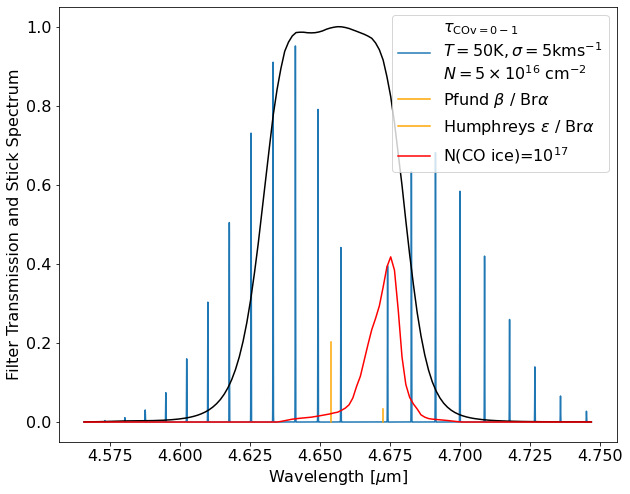

In [111]:
fig = pl.figure()
assert np.all(fig.get_size_inches() == (10,8))

xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
xarr = np.linspace(xarr.min(), xarr.max(), int(1e5))

for T in [50, ]:
    mod = pyspeckitmodels.co_vibration.tau_of_N(xarr.to(u.cm).value, 5e16, T, width=5)
    L, = pl.plot(xarr, mod, label="$\\tau_{{\\mathrm{{CO v=0-1}}}}$\n$T={T} \\mathrm{{K}}, \sigma=5 \mathrm{{km s^{{-1}}}}$\n$ N=5\\times10^{{16}}\\mathrm{{~cm}}^{{-2}}$".format(T=T))
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_466['Transmission']/wavelength_table_466['Transmission'].max(),
        color='k')

for el in range(1,7):
    for eu in range(2,30):
        de = eu - el
        if de >= 1 and de < 6:
            series = name_num_map[el]
            trans = greek_num_map[de]
            scale = d1e41e4[(eu, el)] / d1e41e4[(5,4)]
            wl = (rrl(el, de)*u.GHz).to(u.um, u.spectral())
            if (wl > xarr.min()) & (wl < xarr.max()):
                pl.plot([wl.value, wl.value], [0, scale], color='orange', label=f'{series.capitalize()} $\\{trans}$ / Br$\\alpha$')

pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("Filter Transmission and Stick Spectrum")
fig.savefig(f'{basepath}/paper_figures/F466N_StickSpectrum.pdf', bbox_inches='tight')



mol = load_molecule_ocdb('co')
mod = absorbed_spectrum(1e17*u.cm**-2, mol, return_tau=True, xarr=xarr)

#pl.plot(mol['Wavelength'], mol['k']/mol['k'].max(), color='r', label='CO ice')
pl.plot(xarr, mod, color='r', label='N(CO ice)=10$^{17}$')

pl.legend(loc='best')
fig.savefig(f'{basepath}/paper_figures/F466N_StickSpectrum_withice.pdf', bbox_inches='tight')

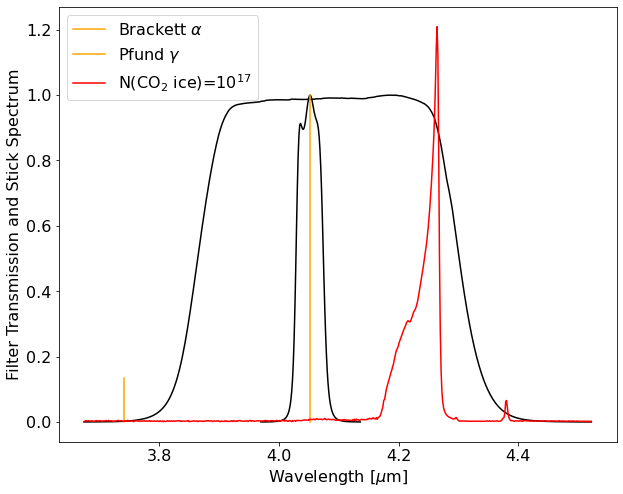

In [112]:
fig = pl.figure()
assert np.all(fig.get_size_inches() == (10,8))

xarr = wavelength_table_410['Wavelength'].quantity.to(u.um)
xarr = np.linspace(xarr.min(), xarr.max(), int(1e5))

xarr = wavelength_table_410['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_410['Transmission']/wavelength_table_410['Transmission'].max(),
        color='k')
pl.plot(wavelength_table_405['Wavelength'].quantity.to(u.um),
        wavelength_table_405['Transmission']/wavelength_table_405['Transmission'].max(),
        color='k')

for el in range(1,7):
    for eu in range(2,30):
        de = eu - el
        if de >= 1 and de < 6:
            series = name_num_map[el]
            trans = greek_num_map[de]
            scale = d1e41e4[(eu, el)] / d1e41e4[(5,4)]
            wl = (rrl(el, de)*u.GHz).to(u.um, u.spectral())
            if (wl > xarr.min()) & (wl < xarr.max()):
                pl.plot([wl.value, wl.value], [0, 1*scale], color='orange', label=f'{series.capitalize()} $\\{trans}$')

pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("Filter Transmission and Stick Spectrum")
fig.savefig(f'{basepath}/paper_figures/F410NF405N_StickSpectrum.pdf', bbox_inches='tight')



mol = load_molecule_ocdb('co2')
mod = absorbed_spectrum(1e17*u.cm**-2, mol, return_tau=True, xarr=xarr)

pl.plot(xarr, mod, color='r', label='N(CO$_2$ ice)=10$^{17}$')

pl.legend(loc='best')
fig.savefig(f'{basepath}/paper_figures/F410N405N_StickSpectrum_withice.pdf', bbox_inches='tight')